In [1]:
import pandas as pd
import numpy as np
import pprint
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('train.csv')

# frac - specifies 80%
# random_state - it saves the current state of the split. Used for reproducability
# Spliting data int Train-Validation[80-20]
train = data.sample(frac = 0.8, random_state = 200)
validation = data.drop(train.index)
categorical_train_data = train.iloc[:, 5:10]
categorical_validation_data = validation.iloc[:, 5:10]

In [3]:
def calc_entropy(table):
    target = table.keys()[-1] # target -> Label's column
    entropy = 0
    values = table[target].unique() # Finds the unique values in target variable, i.e. [0, 1]
    for value in values:
        '''
            total count of 0's         total count of 1's
            -------------------   ,    ---------------------  = frac
            total numbers of rows      total number of rows
        '''
        frac = table[target].value_counts()[value]/len(table[target])
        if frac == 0:
            return 0
        entropy += -frac*np.log2(frac)
    return(entropy) # returns entropy of whole dataset
# print(calc_entropy(categorical_train_data))

In [4]:
def calc_info_attribute(table, attribute, mode):
    target = table.keys()[-1]
    variables = table[attribute].unique() # get unique variables in specified attribute
    target_variables = table[target].unique() # get unique in target, i.e. [0, 1]
    info = 0
    if mode is 'entropy':
        for v in variables:
            entropy = 0
            for target_v in target_variables:
                n = len(table[attribute][table[attribute] == v][table[target] == target_v])
                d = len(table[attribute][table[attribute] == v])
                frac1 = n/(d + np.finfo(float).eps) # eps - smallest representable number such that 1.0 + eps != 1.0
                if frac1 == 0:
                    entropy += 0
                else:
                    entropy += -frac1 * np.log2(frac1)
            frac2 = d/len(table)
            info += -frac2 * entropy
        return abs(info)
    elif mode is 'gini':
        num_of_ones = table['left'].tolist().count(1)
        p = num_of_ones/float(len(data.index))
        gini_index = 2*p*(1-p)
        return gini_index
    elif mode is 'misclassification':
        num_of_ones = table['left'].tolist().count(1)
        p = num_of_ones/float(len(data.index))
        missclasification = min(p,1-p)
        return missclasification
# print(calc_info_attribute(train, 'salary', 'gini'))

In [5]:
def winner_attribute(table, attribute_list):
    info_gain = []
#     print(attribute_list)
    if len(attribute_list) == 1:
        return attribute_list[0]
    for attribute in attribute_list:
        info_gain.append(calc_entropy(table) - calc_info_attribute(table, attribute, 'misclassification'))
    return attribute_list[np.argmax(info_gain)]

In [6]:
def build_tree(table, prev_table, attribute_list, tree = None):
    if len(table['left'].unique()) <= 1:
        return {'leaf' : table['left'].unique()[0]}
    elif len(table) == 0:
        return {'leaf': np.unique(table['left'])[np.argmax(np.unique(table['left'], return_counts = True)[1])]}
    elif len(attribute_list) == 0:
        return {'leaf': np.unique(table['left'])[np.argmax(np.unique(table['left'], return_counts = True)[1])]}
    node = winner_attribute(table, attribute_list)
    attribute_list.remove(node)
    if tree is None:
        tree = {}
        tree[node] = {}
        tree['default'] = np.unique(table['left'])[(np.argmax(np.unique(table['left'], return_counts = True)[1]))]
    for v in table[node].unique():
        mod_table = table.where(table[node] == v).dropna()
        tree[node][v] = build_tree(mod_table, table, attribute_list[:])
    return tree

t = build_tree(categorical_train_data, categorical_train_data, ['work_accident', 'promotion_last_5years', 'sales', 'salary'])
# pprint.pprint(t)

In [7]:
def pred(query, tree):
    try:
        if list(tree.keys())[0] == 'leaf':
            return tree['leaf']
        if list(tree.keys())[0] is 'default':
            val = query[list(tree.keys())[1]]
            next = list(tree.keys())[1]
        else:
            val = query[list(tree.keys())[0]]
            next = list(tree.keys())[0]
        return pred(query, tree[next][val])
    except:
        return 0

In [8]:
predicted = []
def prediction(tree, data):
    for index, row in data.iterrows():
        predicted.append(pred(row, tree))
prediction(t, categorical_validation_data)

In [9]:
def calc_metrics(predictions, actual):
    tp, tn, fp, fn = 0, 0, 0, 0
    for i in range(len(actual)):
        if actual[i] == predictions[i] and actual[i] == 1:
            tp += 1
        elif actual[i] == predictions[i] and actual[i] == 0:
            tn += 1
        elif actual[i] != predictions[i] and actual[i] == 0:
            fp += 1
        else:
            fn += 1
    accuracy = (tn + tp)/(tn + tp + fp + fn)
#     precision = tp/(tp + fp)
#     recall = tp/(tp + fn)
#     a = 1/precision
#     b = 1/recall
#     f1 = 2/(a + b)
    print('Accuracy - ', accuracy)
#     print('Precision - ', precision)
#     print('Recall - ', recall)
#     print('F1 Score - ', f1)
#     print('True Positive - ', tp)
#     print('True Negative - ', tn)
#     print('False Positive - ', fp)
#     print('False Negative - ', fn)
    
    return 1-accuracy

target = categorical_validation_data['left'].tolist()

calc_metrics(predicted, target)

Accuracy -  0.7789145907473309


0.22108540925266906

In [10]:
def make_bins(data):
    category_dict = {}
    label_dict = {}
    average_dict = {}
    for attribute in ['satisfaction_level', 'last_evaluation', 'number_project', 'average_montly_hours', 'time_spend_company']:
        max_counts = []
        data.sort_values(attribute, inplace = True)
        
        for val in data[attribute].unique():
            t=data[data[attribute]==val]
            max_counts.append([val, np.unique(t['left'])[np.argmax(np.unique(t['left'], return_counts = True)[1])]])
        category_dict[attribute] = max_counts
#     print(category_dict)
    
    for key in category_dict.keys():
        label = 0
        label_list = []
        average_list = []
        for i in range(len(category_dict[key])-1):
            if category_dict[key][i][1] == category_dict[key][i+1][1]:
                label_list.append(label)
            else:
                print()
                label += 1
                label_list.append(label)
                average_list.append([(category_dict[key][i][0] + category_dict[key][i+1][0])/2, label])
        average_dict[key] = average_list
        label_dict[key] = label_list
    return average_dict
make_bins(train)

{'average_montly_hours': [[126.5, 1],
  [132.5, 2],
  [274.5, 3],
  [279.5, 4],
  [280.5, 5],
  [282.5, 6],
  [287.5, 7]],
 'last_evaluation': [[0.445, 1], [0.475, 2], [0.995, 3]],
 'number_project': [[2.5, 1], [5.5, 2]],
 'satisfaction_level': [[0.11499999999999999, 1],
  [0.355, 2],
  [0.46499999999999997, 3]],
 'time_spend_company': [[4.5, 1], [5.5, 2]]}

In [11]:
def numerical_to_categorical(data):
    average_dict = make_bins(data)
    print (average_dict)
    for key in average_dict.keys():
        data.sort_values(key, inplace = True)
        new_column = []
        i = 0
        for index, row in data.iterrows():
            if row[key] <= average_dict[key][i][0]:
                new_column.append(average_dict[key][i][1]-1)
            elif i < len(average_dict[key])-1:
                i = i + 1
                new_column.append(average_dict[key][i][1]-1)
            else:
                new_column.append(average_dict[key][i][1])
        data.drop(key, axis = 1)
        column = pd.Series(new_column)
        data[key] = column.values
    return data, average_dict

In [12]:
def numerical_to_categorical_validation(data, average_dict):
    for key in average_dict.keys():
        data.sort_values(key, inplace = True)
        new_column = []
        i = 0
        for index, row in data.iterrows():
            if row[key] <= average_dict[key][i][0]:
                new_column.append(average_dict[key][i][1]-1)
            elif i < len(average_dict[key])-1:
                i = i + 1
                new_column.append(average_dict[key][i][1]-1)
            else:
                new_column.append(average_dict[key][i][1])
        data.drop(key, axis = 1)
        column = pd.Series(new_column)
        data[key] = column.values
    return data


In [13]:
discrete_train_data, average_dict = numerical_to_categorical(train)
tree = build_tree(discrete_train_data, discrete_train_data, ['satisfaction_level', 'last_evaluation', 'number_project', 'average_montly_hours', 'time_spend_company', 'work_accident', 'promotion_last_5years', 'sales', 'salary'])
# pprint.pprint(tree)


















{'last_evaluation': [[0.445, 1], [0.475, 2], [0.995, 3]], 'number_project': [[2.5, 1], [5.5, 2]], 'average_montly_hours': [[126.5, 1], [132.5, 2], [274.5, 3], [279.5, 4], [280.5, 5], [282.5, 6], [287.5, 7]], 'satisfaction_level': [[0.11499999999999999, 1], [0.355, 2], [0.46499999999999997, 3]], 'time_spend_company': [[4.5, 1], [5.5, 2]]}


In [14]:
discrete_validation_data = numerical_to_categorical_validation(validation, average_dict)
predicted = []
prediction(tree, discrete_validation_data)
target = validation['left'].tolist()
calc_metrics(predicted, target)

Accuracy -  0.9612989323843416


0.03870106761565839

0
Accuracy -  0.7784697508896797
1
Accuracy -  0.9016903914590747
2
Accuracy -  0.9096975088967971
3
Accuracy -  0.9292704626334519
4
Accuracy -  0.9332740213523132
5
Accuracy -  0.9612989323843416
6
Accuracy -  0.9635231316725978
7
Accuracy -  0.9635231316725978
8
Accuracy -  0.9648576512455516
9
Accuracy -  0.9612989323843416


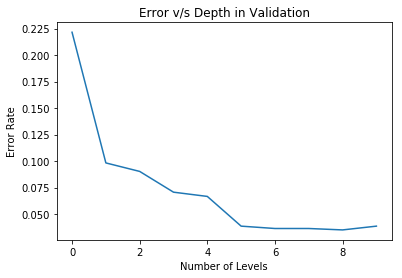

In [15]:
new_prediction_dict = {0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: []}
def prediction_util(query, tree, current_depth, max_depth):
    try:
        if list(tree.keys())[0] == 'leaf':
            new_prediction_dict[max_depth].append(tree['leaf'])
            return
        if list(tree.keys())[0] == 'default':
            val = query[list(tree.keys())[1]]
            next = list(tree.keys())[1]
        else:
            val = query[list(tree.keys())[0]]
            next = list(tree.keys())[0]
        if(current_depth == max_depth):
            new_prediction_dict[current_depth].append(tree['default'])
            return
        prediction_util(query, tree[next][val], current_depth + 1, max_depth)
    except:
        new_prediction_dict[max_depth].append(0)

def new_prediction(tree, data, max_depth):
    for index, row in data.iterrows():
        prediction_util(row, tree, 0, max_depth)
for i in range(10):
    new_prediction(tree, validation, i)
error = []
target = validation['left'].tolist()
for i in range(10):
    print(i)
    error.append(calc_metrics(new_prediction_dict[i], target))
plt.plot([i for i in range(0, 10)], error)
plt.title('Error v/s Depth in Validation')
plt.xlabel('Number of Levels')
plt.ylabel('Error Rate')
plt.show()

0
Accuracy -  0.7578420467185762
1
Accuracy -  0.8919911012235817
2
Accuracy -  0.9010011123470523
3
Accuracy -  0.9191323692992214
4
Accuracy -  0.92146829810901
5
Accuracy -  0.9586206896551724
6
Accuracy -  0.9592880978865406
7
Accuracy -  0.9596218020022247
8
Accuracy -  0.9650723025583983
9
Accuracy -  0.9692992213570634


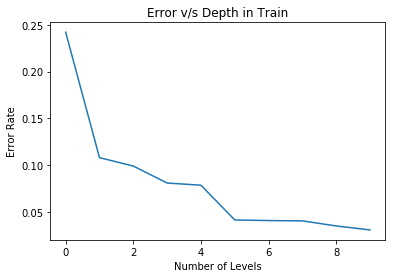

In [16]:
new_prediction_dict = {0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: []}
for i in range(10):
    new_prediction(tree, train, i)
error = []
target = train['left'].tolist()
for i in range(10):
    print(i)
    error.append(calc_metrics(new_prediction_dict[i], target))
plt.plot([i for i in range(0, 10)], error)
plt.title('Error v/s Depth in Train')
plt.xlabel('Number of Levels')
plt.ylabel('Error Rate')
plt.show()

[1, 5, 18, 48, 137, 269, 430, 608, 1060, 1639]


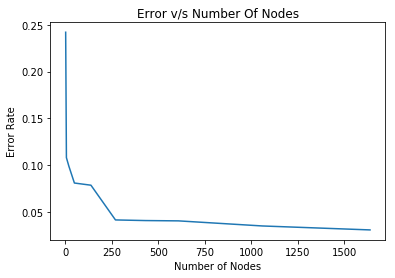

In [17]:
def num_of_nodes(tree,depth,cur_depth,list_num_nodes):
    if cur_depth==depth:
        list_num_nodes[depth]=list_num_nodes[depth]+1
    elif cur_depth<depth:
        for key in tree.keys():
            if key == 'leaf':
                list_num_nodes[depth]=list_num_nodes[depth]+1
            elif key != 'default':
                for val in tree[key]:
                    num_of_nodes(tree[key][val],depth,cur_depth+1,list_num_nodes)
list_num_nodes=[]                
for i in range(10):        
    list_num_nodes.append(0)
    num_of_nodes(tree,i,0,list_num_nodes)
for i in range(1,10):
    list_num_nodes[i]=list_num_nodes[i-1] + list_num_nodes[i]
print(list_num_nodes)
plt.plot(list_num_nodes, error)
plt.title('Error v/s Number Of Nodes')
plt.xlabel('Number of Nodes')
plt.ylabel('Error Rate')
plt.show()